# Flight Analysis

Update the flight report for a given flight/test campaign here: [Flight Reports](https://docs.google.com/document/d/1VsCrQUb__Pi3hgEoIxLOPsOpnpXVnwqD2DVSPG8jg84/edit#)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from flight_plot_utils import load_csv, plot_angle, plot_rate

In [3]:
%matplotlib notebook

# Data Processing

In [21]:
# Load flight logs
flight_df = load_csv("flight_136")
flight_df.head(n=1500)

,t,is_crashed,roll,pitch,yaw,p,q,r,throttle,p_cmd,...,pitch_pid_out,yaw_pid_out,motor_fl,motor_bl,motor_fr,motor_br,pwm_fl,pwm_bl,pwm_fr,pwm_br
0,7052,0,3.3750,0.9375,-0.3125,0.06,-0.06,-0.118750,-1.000,0.0,...,0.000036,0.000072,0.000000,0.000000,0.000000,0.000000,0,0,0,0
1,7064,0,0.0000,0.0000,-0.3125,-14.06,-3.97,-0.124688,-1.000,0.0,...,0.002396,0.000075,0.000000,0.000000,0.000000,0.000000,819,819,819,819
2,7074,0,0.0000,0.0000,-0.3125,0.00,-0.18,-0.184359,-1.000,0.0,...,0.000108,0.000111,0.000000,0.000000,0.000000,0.000000,819,819,819,819
3,7084,0,0.0000,0.0000,-0.3125,-0.12,-0.18,0.050157,-1.000,0.0,...,0.000108,-0.000030,0.000000,0.000000,0.000000,0.000000,819,819,819,819
4,7094,0,0.0000,0.0000,-0.3125,0.06,0.00,0.002508,-1.000,0.0,...,0.000000,-0.000002,0.000000,0.000000,0.000000,0.000000,819,819,819,819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,22978,0,-10.1875,2.0625,64.8750,11.84,-6.52,-54.927135,0.342,0.0,...,0.003975,0.032895,0.371529,0.297788,0.320422,0.378262,1123,1095,1081,1161
1496,22988,0,-9.5625,2.0625,64.8125,8.23,-5.28,-67.405731,0.342,0.0,...,0.003236,0.040407,0.380468,0.293184,0.310003,0.384345,1130,1092,1073,1166
1497,23005,0,-8.8750,2.1250,64.7500,7.13,-5.10,-68.029655,0.342,0.0,...,0.003126,0.040790,0.381404,0.293573,0.308848,0.384175,1131,1092,1072,1166
1498,23018,0,-7.3750,2.2500,64.6875,4.34,-7.00,-81.954605,0.342,0.0,...,0.004269,0.049172,0.392603,0.285721,0.299935,0.389741,1140,1085,1064,1171


In [22]:
# Time - DF -> Numpy
t_df = flight_df['t']
t_np = t_df.to_numpy(dtype=np.int32)
t_np = t_np / 1000

# Crashed flag
crash_df = flight_df[['is_crashed']]
crash_np = crash_df.to_numpy()

# Roll / Pitch / Yaw - DF -> Numpy
rpy_df = flight_df[['roll', 'pitch', 'yaw']]
rpy_np = rpy_df.to_numpy()

# Roll / Pitch / Yaw Commands - DF -> Numpy
rpy_cmd_df = flight_df[['roll_cmd', 'pitch_cmd', 'yaw_cmd']]
rpy_cmd_np = rpy_cmd_df.to_numpy()

# Roll / Pitch / Yaw Rates - DF -> Numpy
pqr_df = flight_df[['p', 'q', 'r']]
pqr_np = pqr_df.to_numpy()

# PID Outputs - DF -> Numpy
pid_df = flight_df[['roll_pid_out', 'pitch_pid_out', 'yaw_pid_out', 'p_cmd', 'q_cmd', 'r_cmd']]
pid_np = pid_df.to_numpy()

# Motor % - DF -> Numpy
power_df = flight_df[['motor_fl', 'motor_bl', 'motor_fr', 'motor_br']]
power_np = power_df.to_numpy()

# Throttle - DF -> Numpy
throttle_df = flight_df['throttle']
throttle_np = throttle_df.to_numpy()

In [23]:
# Trim off the pre-flight data where throttle wasn't up.
init_idx = flight_df.index[flight_df['throttle'] >= 0.0].to_list()[0]

# Plotting indices
idx_start = init_idx
idx_end = np.size(t_np)

# Clip variables
t_clip = t_np[idx_start:idx_end]

In [24]:
""" 
Data clipping
"""

is_crash = crash_np[idx_start:idx_end]
throttle = throttle_np[idx_start:idx_end]

roll = rpy_np[idx_start:idx_end, 0]
pitch = rpy_np[idx_start:idx_end, 1]
yaw = rpy_np[idx_start:idx_end, 2]

roll_cmd = rpy_cmd_np[idx_start:idx_end, 0]
pitch_cmd = rpy_cmd_np[idx_start:idx_end, 1]
yaw_cmd = rpy_cmd_np[idx_start:idx_end, 2]

p = pqr_np[idx_start:idx_end, 0]
q = pqr_np[idx_start:idx_end, 1]
r = pqr_np[idx_start:idx_end, 2]

p_pid = pid_np[idx_start:idx_end, 0]
q_pid = pid_np[idx_start:idx_end, 1]
r_pid = pid_np[idx_start:idx_end, 2]
roll_pid = pid_np[idx_start:idx_end, 3]
pitch_pid = pid_np[idx_start:idx_end, 4]
yaw_pid = pid_np[idx_start:idx_end, 5]

# Note: p,q,r cmds are the outer loop PID outputs.
p_cmd = roll_pid
q_cmd = pitch_pid
r_cmd = yaw_pid

# Crash Detection

<IPython.core.display.Javascript object>


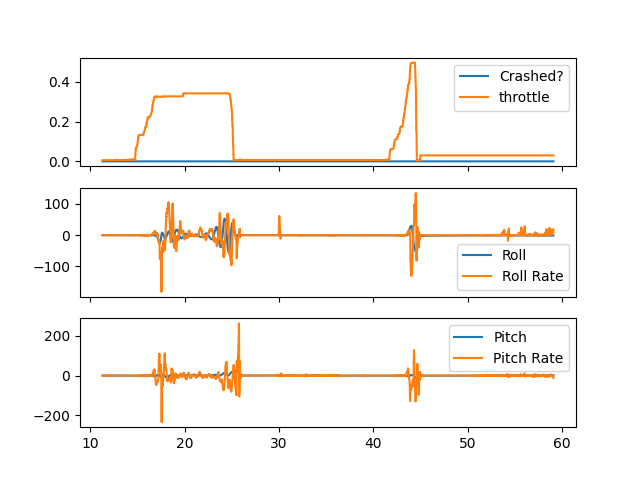

In [25]:
f, axs = plt.subplots(3, sharex=True)

axs[0].plot(t_clip, is_crash, label="Crashed?")
axs[0].plot(t_clip, throttle, label="throttle")
# axs[0].set_ylabel("Crash Status")
axs[0].legend()

axs[1].plot(t_clip, roll, label="Roll")
axs[1].plot(t_clip, p, label="Roll Rate")
axs[1].legend()

axs[2].plot(t_clip, pitch, label="Pitch")
axs[2].plot(t_clip, q, label="Pitch Rate")
axs[2].legend()

plt.show()

# Roll Control

## Inner Loop

<IPython.core.display.Javascript object>


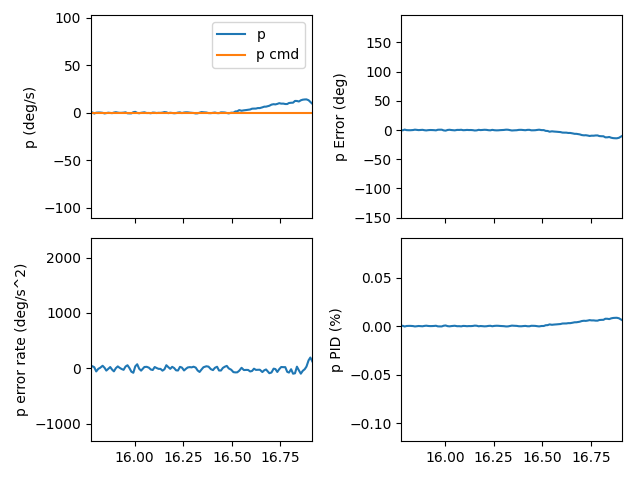

In [26]:
plot_rate(t_clip, p_cmd, p, np.gradient(p, t_clip), p_pid, "p")

## Outer Loop

<IPython.core.display.Javascript object>


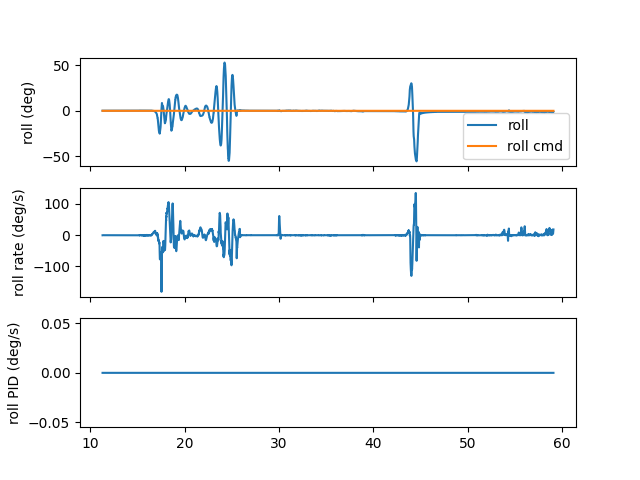

In [27]:
plot_angle(t_clip, roll_cmd, roll, p, np.degrees(roll_pid), label="roll")

# Pitch Control

## Inner Loop

<IPython.core.display.Javascript object>


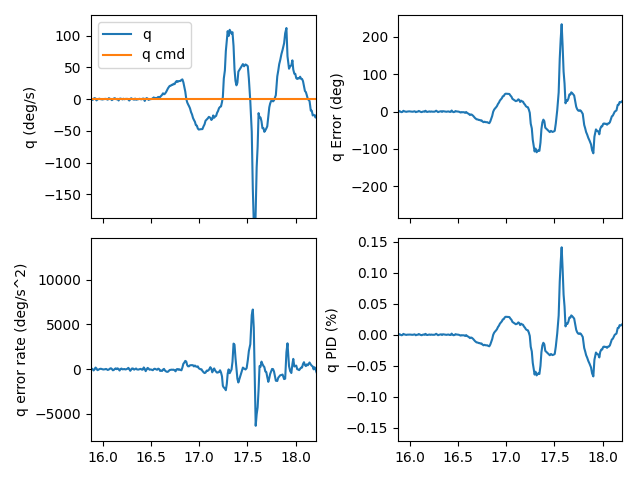

In [28]:
plot_rate(t_clip, q_cmd, q, np.gradient(q, t_clip), q_pid, "q")

## Outer Loop

<IPython.core.display.Javascript object>


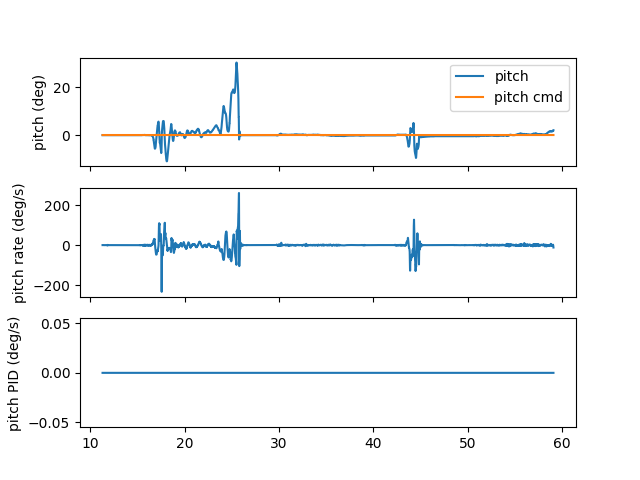

In [29]:
plot_angle(t_clip, pitch_cmd, pitch, q, np.degrees(pitch_pid), label="pitch")

# Yaw Control

## Inner Loop

<IPython.core.display.Javascript object>


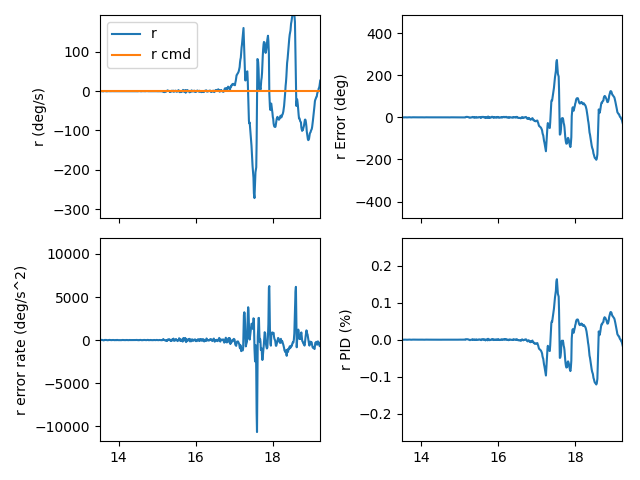

In [30]:
plot_rate(t_clip, r_cmd, r, np.gradient(r, t_clip), r_pid, "r")

## Outer Loop

<IPython.core.display.Javascript object>


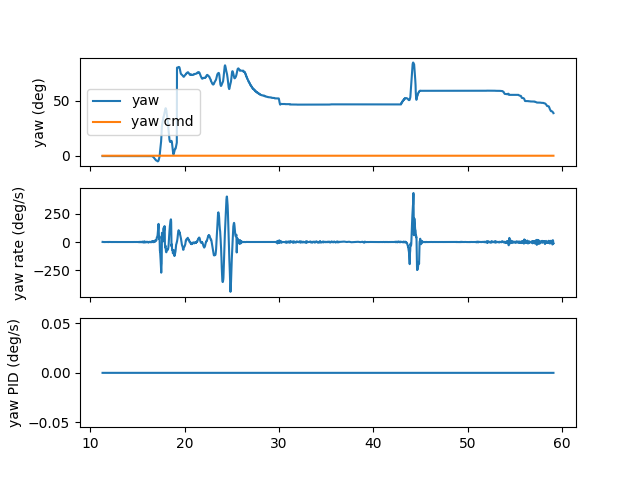

In [31]:
plot_angle(t_clip, yaw_cmd, yaw, r, yaw_pid, label="yaw")

# Motor Allocation

In [32]:
MAX_PWM = 2**14 - 1

def motor_pwm_to_pct(pwm, min_pwm_duty=0.051*MAX_PWM, max_pwm_duty=0.1*MAX_PWM):
    # Get PWM range in microseconds
    duty_range = max_pwm_duty - min_pwm_duty
    
    # Get the pwm distance from the lower limit
    pwm_offset = pwm - min_pwm_duty
    
    # Find the power
    power = pwm_offset / duty_range
    
    return power

<IPython.core.display.Javascript object>


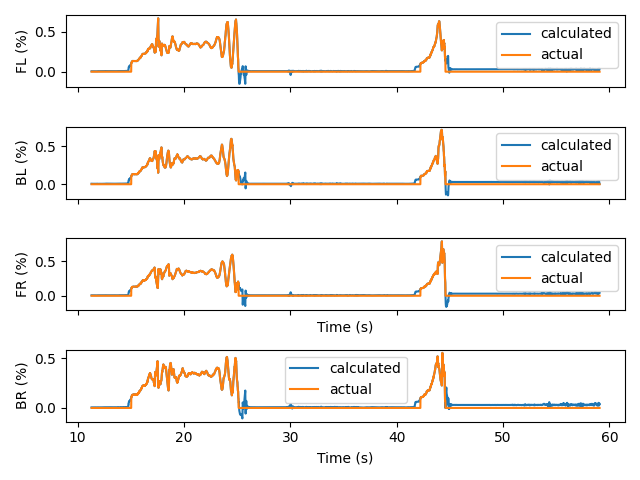

In [33]:
throttle_pct = throttle #* 0 + 0.5
front_left_out  = throttle_pct - p_pid + q_pid + r_pid
back_left_out   = throttle_pct - p_pid - q_pid - r_pid
front_right_out = throttle_pct + p_pid + q_pid - r_pid
back_right_out  = throttle_pct + p_pid - q_pid + r_pid

# Get actual motor powers
fl_power = power_np[idx_start:idx_end, 0]
bl_power = power_np[idx_start:idx_end, 1]
fr_power = power_np[idx_start:idx_end, 2]
br_power = power_np[idx_start:idx_end, 3]

# Plotting expected motor thrust allocation
f, axs = plt.subplots(4, sharex=True)

axs[0].plot(t_clip, front_left_out, label='calculated')
axs[0].plot(t_clip, fl_power, label='actual')
axs[0].set_ylabel("FL (%)")
axs[0].legend()

axs[1].plot(t_clip, back_left_out, label='calculated')
axs[1].plot(t_clip, bl_power, label='actual')
axs[1].set_ylabel("BL (%)")
axs[1].legend()

axs[2].plot(t_clip, front_right_out, label='calculated')
axs[2].plot(t_clip, fr_power, label='actual')
axs[2].set_ylabel("FR (%)")
axs[2].set_xlabel("Time (s)")
axs[2].legend()

axs[3].plot(t_clip, back_right_out, label='calculated')
axs[3].plot(t_clip, br_power, label='actual')
axs[3].set_ylabel("BR (%)")
axs[3].set_xlabel("Time (s)")
axs[3].legend()

f.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


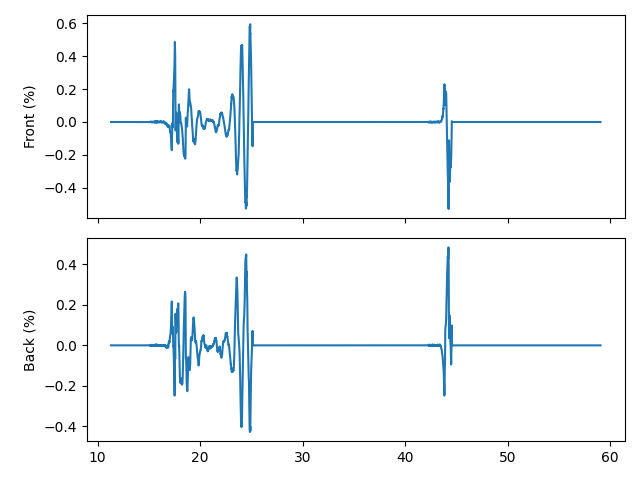

In [34]:
# Left - Right
front_delta = fl_power - fr_power
back_delta  = bl_power - br_power

# Plotting expected motor thrust allocation
f, axs = plt.subplots(2, sharex=True)

axs[0].plot(t_clip, front_delta)
axs[0].set_ylabel("Front (%)")

axs[1].plot(t_clip, back_delta)
axs[1].set_ylabel("Back (%)")

f.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


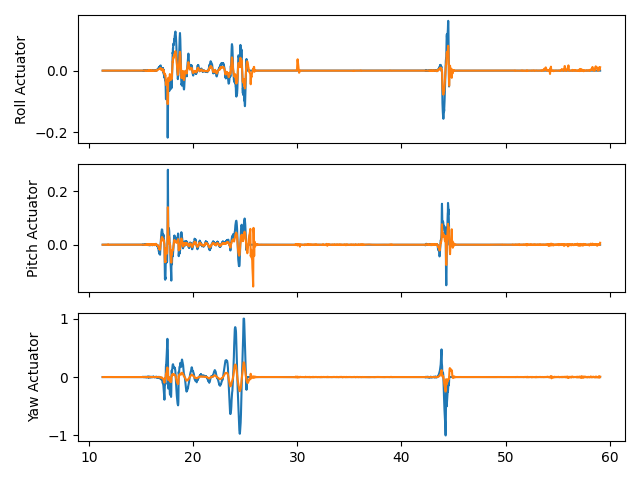

In [40]:
# Motor Vectors
front_power = (fl_power + fr_power) / 2.0
left_power = (fl_power + bl_power) / 2.0
back_power = (bl_power + br_power) / 2.0
right_power = (fr_power + br_power) / 2.0

# Effective controls
motor_roll = right_power - left_power
motor_pitch = front_power - back_power
motor_yaw = (fl_power + br_power) - (fr_power + bl_power)

fig, axs = plt.subplots(3, sharex=True)
axs[0].plot(t_clip, motor_roll)
axs[0].plot(t_clip, p_pid)
axs[0].set_ylabel("Roll Actuator")

axs[1].plot(t_clip, motor_pitch)
axs[1].plot(t_clip, q_pid)
axs[1].set_ylabel("Pitch Actuator")

axs[2].plot(t_clip, motor_yaw)
axs[2].plot(t_clip, r_pid)
axs[2].set_ylabel("Yaw Actuator")

fig.tight_layout()
plt.show()